In [66]:
# !pip install nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [1]:
import pandas as pd
import numpy as np

import requests

import re

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#instalamos una libreria de gender guesser https://pypi.org/project/gender-guesser/
# !pip install gender_guesser
# !pip install xlrd
# !pip install openpyxl
import gender_guesser.detector as gender


# Data

In [68]:
# data = pd.read_csv('/content/ACL_data.csv')
data = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data_without_nulls.csv")
data.head(3)

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS


In [69]:
# filtro nulos segun columna autor
data_original = data.copy() #GUARDO LA DATA ORIGINAL ANTES DE QUITARLE LOS N/A, POR LAS DUDAS, PARA COMPARAR RESULTADOS
data = data.dropna(subset = "AUTHOR")

#XXX/33811 = se perdieron el xx% de los datos.

data.AUTHOR.value_counts()  

Wu, Chuhan  and                    22
Liu, Yang  and                     19
Sawhney, Ramit  and                19
Grabar, Natalia  and               17
Ljube{\v{s}}i{\'c}, Nikola  and    17
                                   ..
Miklashevsky, Alex                  1
Kim, Yekyung                        1
Huber, Christian  and               1
Tittel, Sabine  and                 1
Yngve, Victor H.                    1
Name: AUTHOR, Length: 19048, dtype: int64

In [70]:
data['name'] = data['AUTHOR']\
     .str.replace("[^,A-Za-z\s]+", "", regex = True) \
    .str.extract('(,\s[a-zA-Z]+)', expand=False)\
    .str.replace(', ', '')\
    .str.strip()
#,\s[a-zA-Z]+ 

data['last_name'] = data['AUTHOR'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data['last_name'] = data['last_name'].str.replace(',', '') # le saco la coma

data = data[data.name.str.len() > 1]

data.name.value_counts() #8823 unique

Michael     159
David       156
Daniel      152
John        115
Maria       113
           ... 
Benny         1
YuYun         1
Yoshinao      1
Ioanna        1
Bertram       1
Name: name, Length: 8797, dtype: int64

In [71]:
data.name.isna().sum() #89 
#data.info()#28171 del total 32245 hay 100 que no se que son


0

# GENDER-GUESSER
https://pypi.org/project/gender-guesser/

In [72]:
d = gender.Detector()

#aplico sobre todo el dataset
data['gender_g'] = data['name'].map(lambda x: d.get_gender(x))
data['gender_g'].value_counts()

male             12858
unknown          11154
female            5914
andy              2509
mostly_male        700
mostly_female      357
Name: gender_g, dtype: int64

In [73]:
len(data['gender_g']) #32245 total de registros
len(data['name'].unique()) #7774 unicos
# data['Gender'].isna().sum() 

8797

In [74]:
df1 = data.groupby('gender_g')['name'].nunique()
df1

gender_g
andy              304
female           1388
male             1991
mostly_female      92
mostly_male       144
unknown          4878
Name: name, dtype: int64

# GENDERIZE
## Tratamiento unknown
**TRABAJO SOBRE LOS UNKNOWN y ANDY**
**API PARA TOMAR LOS NOMBERS UNKNOWN** 

In [75]:
#guardo los unknown para consultarlos via API
df_unk = data[(data['gender_g']== 'unknown') | (data['gender_g']== 'andy')]
len(df_unk)

len(df_unk['name'])
len(df_unk['name'].unique())

5182

In [76]:
#guardo los unknown en un dataset separado
unk_names = pd.DataFrame(df_unk['name'].unique())
# df_unk.to_csv("names_unk.csv")

unk_names.head(3)

,0
0,Shuzhou
1,Siddhartha
2,Awantee


Llamamos a una API para ver los nombres que nos faltan

*   con nombres unknown
*   y andy



In [77]:
#api endpoint como solo se podia consultar 1000 por dia lo hicimos en otra pc cambiando la IP

# url= 'https://api.genderize.io'

# list = df_unk['name'].unique()[:3]
# dict ={} 

# for i in list:
#  PARAM = {'name': i}
#  response = requests.get(url = url, params = PARAM)
#  data_i = response.json()
#  gender = data_i['gender']
#  dict[i]=gender

# dict

In [78]:
#guardo el dict en un dataset aparte para trabajarlo separado
#df_names = pd.DataFrame.from_dict(dict, orient="index")
#df_names.to_csv("names950_1949.csv")

In [79]:
#cargo el dataset de los nombres unknown (lo hice por afuera y guarde el dataset)
data_unkn = pd.read_csv("data/data_gender/out.csv")
data_andy = pd.read_csv("data/data_gender/andy.csv")
data_andy.columns = ["name", "gender_ize"]
data_unkn.columns = ["name", "gender_ize"]
data_imp = pd.concat([data_andy, data_unkn], axis = 0)
data_imp.head()

,name,gender_ize
0,Hao,male
1,Ying,female
2,Yue,female
3,Bin,male
4,Yang,male


# Jurafsky data
**Levanto los datasets de ACL por gender**
https://nlp.stanford.edu/pubs/vogeljurafsky12.pdf

https://nlp.stanford.edu/projects/gender/



In [98]:
data_male = pd.read_csv("data/data_gender/acl-male.txt", delimiter="\t", header= None)
data_female = pd.read_csv("data/data_gender/acl-female.txt", delimiter="\t",header= None)
# data_unknow = pd.read_csv("code/data/data_gender/acl-unknown.txt", delimiter="\t",header= None)

data_male.columns =['complete_name']
data_male['name'] = data_male['complete_name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_male['name'] = data_male['name'].str.replace(', ', '') # le saco la coma
data_male['last_name'] = data_male['complete_name'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data_male['last_name'] = data_male['last_name'].str.replace(',', '') # le saco la coma
data_male['gender_jur']='male' #agrego columna de genero# incluyo nombre de columnas


data_female.columns =['complete_name']
data_female['name'] = data_female['complete_name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_female['name'] = data_female['name'].str.replace(', ', '') # le saco la coma
data_female['last_name'] = data_female['complete_name'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data_female['last_name'] = data_female['last_name'].str.replace(',', '') # le saco la coma
data_female['gender_jur']='female' #agrego columna de genero


names = pd.concat([data_female, data_male], axis=0)
names.drop_duplicates(inplace= True)
names["concate_name"] =  names.name + " "+ names.last_name
print(len(names))
names.sample(5)

11932


,complete_name,name,last_name,gender_jur,concate_name
1060,"Chang, Jason S.",Jason,Chang,male,Jason Chang
113,"Ayache, Christelle",Christelle,Ayache,female,Christelle Ayache
4541,"Lyons, Daniel",Daniel,Lyons,male,Daniel Lyons
1244,"Christoudias, Mario",Mario,Christoudias,male,Mario Christoudias
8050,"we, Welf",Welf,we,male,Welf we


In [105]:
count_gender = names.groupby(by = ["concate_name"], as_index= False)["gender_jur"].count().sort_values(ascending = False, by = 'gender_jur')
count_gender_df = count_gender[count_gender["gender_jur"] >= 2]

names.loc[names["concate_name"].isin(count_gender_df["concate_name"]), "gender_jur"] = np.nan
names.sample(5)

,complete_name,name,last_name,gender_jur,concate_name
4147,"Lau, Gerd",Gerd,Lau,male,Gerd Lau
4077,"Lagarda, Antonio L.",Antonio,Lagarda,NaN,Antonio Lagarda
813,"Brooks, James",James,Brooks,male,James Brooks
1936,"Ellison, Noel",Noel,Ellison,male,Noel Ellison
8381,"You, Jia-Ming",Jia,You,male,Jia You


# **UNO TODOS LOS DATASETS**

data = original con gender de GENDER-GUESSER

data_imp =  unknown y andy imputados con la API de genderize

names = dataset que tomamos del ACL (Jurafsky)


In [82]:
#len(data) #32245
#len(data_out) #4411
#len(df_andy) # 290
len(names) #11930

11932

In [113]:
#dfs =[data,data_out]
df=pd.merge(data,data_imp, on="name", how= "left")
df=pd.merge(df, names.drop(["complete_name", "concate_name"], 1), on=["name", "last_name"], how= "left")

df.drop_duplicates(inplace = True)

df.loc[df["gender_g"] == "mostly_male", "gender_g"] = 'male' #cambio mostly_male por male
df.loc[df["gender_g"] == "mostly_female", "gender_g"] = 'female'#cambio mostly_female por female
df.loc[df["gender_g"] == "unknown", "gender_g"] = np.nan

df.sample(3)

/tmp/ipykernel_12396/335155803.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=pd.merge(df, names.drop(["complete_name", "concate_name"], 1), on=["name", "last_name"], how= "left")


,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,last_name,gender_g,gender_ize,gender_jur
21931,2018,A Corpus of Non-Native Written {E}nglish Annot...,We present a corpus of 240 argumentative essay...,"Beigman Klebanov, Beata and",Association for Computational Linguistics,Proceedings of the 2018 Conference of the Nort...,INPROCEEDINGS,Beata,Klebanov,female,NaN,female
3384,2021,NADI} 2021: The Second Nuanced {A}rabic Dialec...,We present the findings and results of theSeco...,"Abdul-Mageed, Muhammad and",Association for Computational Linguistics,Proceedings of the Sixth Arabic Natural Langua...,INPROCEEDINGS,Muhammad,Mageed,male,NaN,NaN
16363,2019,Gendered Pronoun Resolution using {BERT} and a...,The resolution of ambiguous pronouns is a long...,"Chada, Rakesh",Association for Computational Linguistics,Proceedings of the First Workshop on Gender Bi...,INPROCEEDINGS,Rakesh,Chada,male,NaN,NaN


In [114]:
print(f'longitud data original {len(data)} y final {len(df.drop_duplicates() )}' )

longitud data original 33492 y final 33492


In [108]:
 df[df.duplicated(subset="ABSTRACT", keep=False)].sort_values(by= "ABSTRACT", ascending= False).to_csv('data/duplicated.csv')

In [196]:
# df.to_csv('code/data/data_gender/data_gender.csv', index = False)

# Imputacion final


In [115]:
df["gender_final"] = np.where(
    df["gender_jur"].isna(),
    df["gender_g"],          
    df["gender_jur"]
    )
    
df["gender_final"] = np.where(
    df["gender_final"].isna(),
    df["gender_ize"],          
    df["gender_final"]
    )  

df[( df["gender_final"].isna() )   ]

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,last_name,gender_g,gender_ize,gender_jur,gender_final
11,2022,S}tereo{KG}: Data-Driven Knowledge Graph Const...,Analyzing ethnic or religious bias is importan...,"Deshpande, Awantee and",Association for Computational Linguistics,Proceedings of the Sixth Workshop on Online Ab...,INPROCEEDINGS,Awantee,Deshpande,NaN,NaN,NaN,NaN
35,2022,Narrative Detection and Feature Analysis in On...,Narratives have been shown to be an effective ...,"Ganti, Achyutarama and",Association for Computational Linguistics,Proceedings of the 4th Workshop of Narrative U...,INPROCEEDINGS,Achyutarama,Ganti,NaN,NaN,NaN,NaN
80,2022,Attributing Fair Decisions with Attention Inte...,The widespread use of Artificial Intelligence ...,"Mehrabi, Ninareh and",Association for Computational Linguistics,Proceedings of the 2nd Workshop on Trustworthy...,INPROCEEDINGS,Ninareh,Mehrabi,NaN,NaN,NaN,NaN
95,2022,Samanantar: The Largest Publicly Available Par...,"We present Samanantar, the largest publicly av...","Ramesh, Gowtham and",MIT Press,NaN,ARTICLE,Gowtham,Ramesh,NaN,NaN,NaN,NaN
108,2022,VILA}: Improving Structured Content Extraction...,Accurately extracting structured content from ...,"Shen, Zejiang and",MIT Press,NaN,ARTICLE,Zejiang,Shen,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33664,1991,Probabilistic {LR} Parsing for General Context...,To combine the advantages of probabilistic gra...,"Ng, See-Kiong and",Association for Computational Linguistics,Proceedings of the Second International Worksh...,INPROCEEDINGS,SeeKiong,Ng,NaN,NaN,NaN,NaN
33667,1991,Unification-Based Dependency Parsing of Govern...,This paper describes a unification-based depen...,"Kwon, Hyuk-Chul and",Association for Computational Linguistics,Proceedings of the Second International Worksh...,INPROCEEDINGS,HyukChul,Kwon,NaN,NaN,NaN,NaN
33676,1989,A Sequential Truncation Parsing Algorithm Base...,"In a natural language processing system, a lar...","Su, Keh-Yih and",Carnegy Mellon University,Proceedings of the First International Worksho...,INPROCEEDINGS,KehYih,Su,NaN,NaN,NaN,NaN
33705,1984,A new dictionary structure for bi-directional ...,The importance and structure of MT-dictionary ...,"Loh, Shiu-chang and",NaN,Proceedings of the International Conference on...,INPROCEEDINGS,Shiuchang,Loh,NaN,NaN,NaN,NaN


In [119]:
# df[( df["gender_final"].isna() )   ]
df_final = df[["YEAR",'ABSTRACT', 'AUTHOR', 'gender_g', 'gender_ize', 'gender_jur','gender_final']]
df_final.to_csv("data/data_gender_abstract_year.csv", index = False)

El dataset final lo trabajamos por afuera para ver puntualmente que nos traia

In [210]:
# data_final = pd.read_csv("/content/df_3 _tunned.csv")
data_final = df.copy()

In [ ]:
data_final.head()

,Unnamed: 0,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender_Guesser,Gender_API,Gender_Andy_API,Gender_ACL,Gender=gender3,gender_final_form,gender_final
0,0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male,NaN,NaN,male,True,male,male
1,1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male,NaN,NaN,male,True,male,male
2,2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,male,NaN,NaN,male,True,male,male
3,3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male,NaN,NaN,male,True,male,male
4,4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female,NaN,NaN,male,False,female,female


In [211]:
data_final.loc[data_final["gender_final"] == "Y", "gender_final"] = 'unknown' #cambio mostly_male por male

# **GRAFICOS DE GENDER**

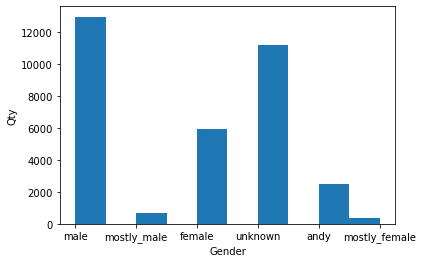

In [212]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(data['gender_g'])  # density=False would make counts
plt.ylabel('Qty')
plt.xlabel('Gender');

TypeError: 'value' must be an instance of str or bytes, not a float

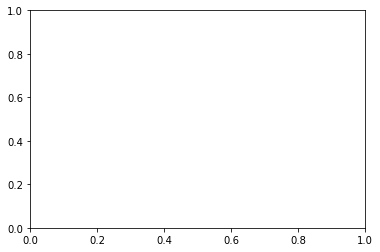

In [213]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(data_final['gender_final'])  # density=False would make counts
plt.ylabel('Qty')
plt.xlabel('Gender');

In [50]:
table=data_final.value_counts(['YEAR', 'gender_final'])

In [51]:
table

YEAR  gender_final
2020  male            4430
2021  male            4060
2019  male            2986
2018  male            2391
2022  male            2120
                      ... 
1997  female             1
1995  unknown            1
1997  unknown            1
1995  female             1
1993  unknown            1
Length: 83, dtype: int64

In [61]:
#gender per year

per_year = pd.crosstab(data_final.YEAR, data_final.gender_final)
per_year

gender_final,female,male,unknown
YEAR,,,
1989,2,24,2
1991,3,24,0
1993,5,35,1
1995,1,20,1
1997,1,25,1
1998,24,23,4
2000,14,49,4
2001,16,38,5
2002,20,60,7


In [ ]:
#reseteo el index para quedarme con la columna año
per_year= per_year.reset_index()
per_year.info()

In [80]:
#creamos el total por año
per_year['total'] = per_year['female'] + per_year['male'] + per_year['unknown']


gender_final,YEAR,female,male,unknown,total
0,1989,2,24,2,28
1,1991,3,24,0,27
2,1993,5,35,1,41
3,1995,1,20,1,22
4,1997,1,25,1,27


In [82]:
#creo % por genero por año
per_year['female_%'] = per_year['female'] / per_year['total'] * 100
per_year['male_%'] = per_year['male'] / per_year['total'] *100
per_year['unknown_%'] = per_year['unknown'] / per_year['total'] *100
per_year.head()

gender_final,YEAR,female,male,unknown,total,female_%,male_%,unknown_%
0,1989,2,24,2,28,7.142857,85.714286,7.142857
1,1991,3,24,0,27,11.111111,88.888889,0.000000
2,1993,5,35,1,41,12.195122,85.365854,2.439024
3,1995,1,20,1,22,4.545455,90.909091,4.545455
4,1997,1,25,1,27,3.703704,92.592593,3.703704


In [83]:
type(per_year)

pandas.core.frame.DataFrame

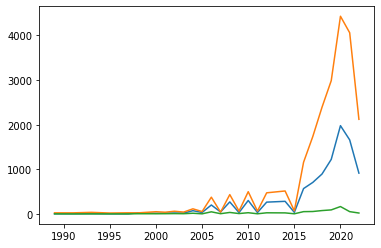

In [79]:
#gender per year

import numpy as np
import matplotlib.pyplot as plt

Y = per_year['female']
M = per_year['male']
Z= per_year['unknown']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y,X,M,X,Z)
fig.show()

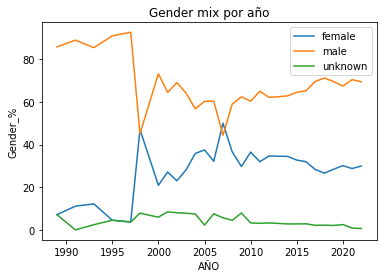

In [95]:
Y = per_year['female_%']
M = per_year['male_%']
Z= per_year['unknown_%']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y, label='female')
ax.plot(X,M, label='male')
ax.plot(X,Z, label='unknown')
ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')
fig.show()

In [121]:
per_year.reset_index()
per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR       28 non-null     int64  
 1   female     28 non-null     int64  
 2   male       28 non-null     int64  
 3   unknown    28 non-null     int64  
 4   total      28 non-null     int64  
 5   female_%   28 non-null     float64
 6   male_%     28 non-null     float64
 7   unknown_%  28 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 1.9 KB


In [134]:
per_year.set_index('YEAR')
#per_year.head()

gender_final,female,male,unknown,total,female_%,male_%,unknown_%
YEAR,,,,,,,
1989,2,24,2,28,7.142857,85.714286,7.142857
1991,3,24,0,27,11.111111,88.888889,0.000000
1993,5,35,1,41,12.195122,85.365854,2.439024
1995,1,20,1,22,4.545455,90.909091,4.545455
1997,1,25,1,27,3.703704,92.592593,3.703704
1998,24,23,4,51,47.058824,45.098039,7.843137
2000,14,49,4,67,20.895522,73.134328,5.970149
2001,16,38,5,59,27.118644,64.406780,8.474576
2002,20,60,7,87,22.988506,68.965517,8.045977


In [ ]:
per_year.head()

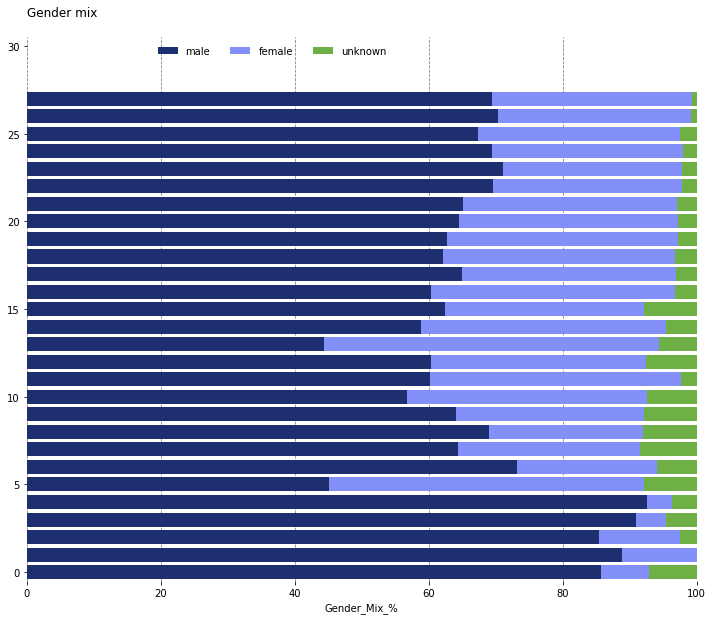

In [136]:


fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
labels = ['male', 'female', 'unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
    left = left + per_year[name]
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

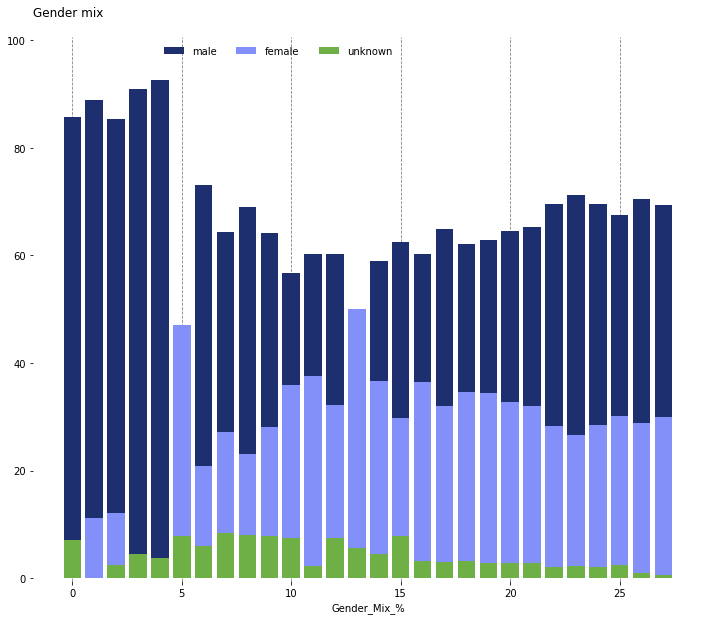

In [138]:


fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
labels = ['male', 'female', 'unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.bar(per_year.index, per_year[name], color=colors[idx])
    
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

IndexError: ignored

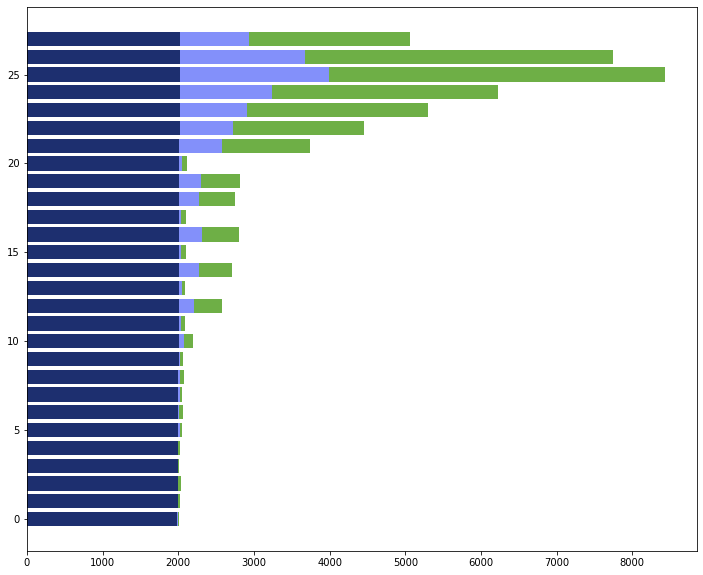

In [141]:
# variables
fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']

title = 'Video Game Sales By Platform and Region\n'
subtitle = 'Proportion of Games Sold by Region'
def plot_stackedbar_p(per_year, labels, colors, title, subtitle):
    fields = per_year.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
    left = len(per_year) * [0]
    for idx, name in enumerate(fields):
        plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
        left = left + per_year[name]
# title and subtitle
    plt.title(title, loc='left')
    plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=4, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()
    
plot_stackedbar_p(per_year, labels, colors, title, subtitle)

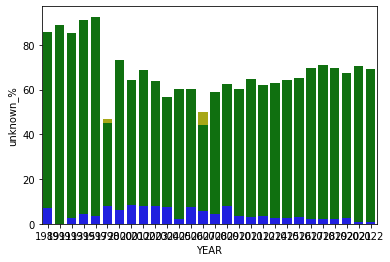

In [107]:
import seaborn as sns

bar_plot1 = sns.barplot(x='YEAR', y='female_%', data=per_year, label="female_%", color="y")
bar_plot2 = sns.barplot(x='YEAR', y='male_%', data=per_year, label="male_%", color="g")
bar_plot3 = sns.barplot(x='YEAR', y='unknown_%', data=per_year, label="unknown_%", color="b")

plt.show()

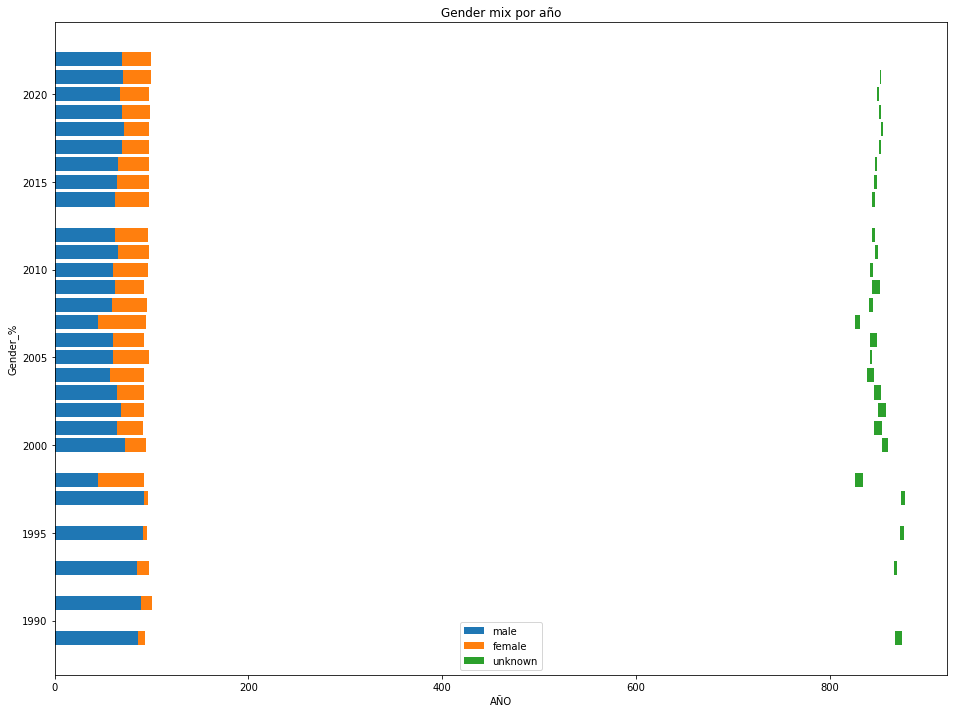

In [133]:
# Define Data

año = per_year['YEAR']
female = per_year['female_%']
male = per_year['male_%']
unknown = per_year['unknown_%']
a = female + male

# Define height of stacked chart


h = 1

# Plot stacked bar chart



# Display
fig, ax = plt.subplots(1, figsize=(16, 12))
ax.barh(año, male, label = 'male')
ax.barh(año, female, left=male, label = 'female')
ax.barh(año, unknown, left=sum(female,male), label = 'unknown')


ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')



plt.show()